<a href="https://colab.research.google.com/github/barnaor97/group21/blob/main/final_deep_learning_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import files
import zipfile
import os

# Upload the original ZIP file
uploaded = files.upload()  # Select the original ZIP file

# Extract the ZIP file
zip_file_name = list(uploaded.keys())[0]
extract_path = "/content/dadaptation"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Change to the extracted directory
os.chdir(extract_path)
print(f"Extracted ZIP to {extract_path}")
print("Files in Current Directory:", os.listdir("."))



Saving dadaptation-main.zip to dadaptation-main.zip
Extracted ZIP to /content/dadaptation
Files in Current Directory: ['dadaptation-main']


In [ ]:
!pip install torchvision
# Run a Python file
import sys
sys.path.append('/content/dadaptation/dadaptation-main')

In [ ]:
%cd /content/dadaptation

/content


In [ ]:
#cifar-10

!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

import tarfile

# Extract the tar.gz file
tar = tarfile.open("cifar-10-python.tar.gz")
tar.extractall("./data")
tar.close()


--2025-01-21 17:15:05--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  46.5MB/s    in 3.8s    

2025-01-21 17:15:09 (42.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
!pip install --upgrade torch torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import NAdam  # Built-in Nadam optimizer

# Define a simple CNN model for CIFAR-10
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Prepare CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define training function
def train_model(model, optimizer, criterion, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")



Files already downloaded and verified


In [ ]:
import os

# Define the file path
file_path = "/content/dadaptation/dadaptation-main/dadaptation/dadapt_asgd.py"
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Content for DAdaptASGD
file_content = """
import torch
from torch.optim import Optimizer
import math

class DAdaptASGD(Optimizer):
    def __init__(self, params, lr=1.0, lambd=0.0001, alpha=0.75, weight_decay=0, d0=1e-6, growth_rate=2):
        if not 0.0 < d0:
            raise ValueError(f"Invalid d0 value: {d0}")
        if not 0.0 < lr:
            raise ValueError(f"Invalid learning rate: {lr}")

        defaults = dict(lr=lr, lambd=lambd, alpha=alpha, weight_decay=weight_decay, d=d0, growth_rate=growth_rate, k=0)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        sk_sq = 0.0

        for group in self.param_groups:
            lr = group['lr']
            lambd = group['lambd']
            alpha = group['alpha']
            weight_decay = group['weight_decay']
            d = group['d']
            growth_rate = group['growth_rate']
            k = group['k']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                if weight_decay != 0:
                    grad.add_(p.data, alpha=weight_decay)

                if 'step_size' not in self.state[p]:
                    self.state[p]['step_size'] = torch.zeros_like(p.data)

                step_size = self.state[p]['step_size']

                # Compute D-adapted step size
                step_size.mul_(alpha).add_(grad, alpha=(1 - alpha))
                sk_sq += (step_size * step_size).sum().item()

        d_hat = d

        if sk_sq > 0:
            d_hat = 2 * math.sqrt(sk_sq)
            d = min(d_hat, d * growth_rate)

        for group in self.param_groups:
            group['d'] = d

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                step_size = self.state[p]['step_size']

                # Update parameter using ASGD rule
                p.data.add_(step_size, alpha=-lr / d)

            group['k'] += 1

        return loss
"""

# Write the file
with open(file_path, "w") as f:
    f.write(file_content)

print(f"File {file_path} created successfully.")

# Run the script to ensure proper initialization
!python {file_path}

File /content/dadaptation/dadaptation-main/dadaptation/dadapt_asgd.py created successfully.


In [ ]:
init_file_path = "/content/dadaptation/dadaptation-main/dadaptation/__init__.py"
new_line = "from .dadapt_asgd import DAdaptASGD\n"

# Read existing lines
with open(init_file_path, "r") as file:
    lines = file.readlines()

# Add new import if not already present
if new_line not in lines:
    with open(init_file_path, "a") as file:
        file.write(new_line)
    print("Line added successfully!")
else:
    print("Line already exists in __init__.py.")

# Run the __init__.py file to ensure module is available
!python {init_file_path}

Line added successfully!
Traceback (most recent call last):
  File "/content/dadaptation/dadaptation-main/dadaptation/__init__.py", line 7, in <module>
    from .dadapt_adagrad import DAdaptAdaGrad
ImportError: attempted relative import with no known parent package


Files already downloaded and verified
Training with ASGD (No D-Adaptation)
Epoch 1, Loss: 2.0491, Accuracy: 27.08%, Time: 56.93s
Epoch 2, Loss: 1.6944, Accuracy: 39.96%, Time: 57.08s
Epoch 3, Loss: 1.4920, Accuracy: 46.84%, Time: 56.58s
Epoch 4, Loss: 1.3741, Accuracy: 51.06%, Time: 56.79s
Epoch 5, Loss: 1.2885, Accuracy: 54.37%, Time: 56.34s
Epoch 6, Loss: 1.2181, Accuracy: 56.91%, Time: 56.71s
Epoch 7, Loss: 1.1561, Accuracy: 59.16%, Time: 56.95s
Epoch 8, Loss: 1.1014, Accuracy: 61.31%, Time: 56.84s
Epoch 9, Loss: 1.0461, Accuracy: 63.51%, Time: 57.02s
Epoch 10, Loss: 0.9993, Accuracy: 64.87%, Time: 56.00s
Epoch 11, Loss: 0.9551, Accuracy: 66.66%, Time: 56.30s
Epoch 12, Loss: 0.9125, Accuracy: 68.29%, Time: 56.05s
Epoch 13, Loss: 0.8720, Accuracy: 69.65%, Time: 56.77s
Epoch 14, Loss: 0.8327, Accuracy: 70.96%, Time: 55.81s
Epoch 15, Loss: 0.7982, Accuracy: 72.34%, Time: 57.12s
Epoch 16, Loss: 0.7628, Accuracy: 73.54%, Time: 57.08s
Epoch 17, Loss: 0.7283, Accuracy: 74.81%, Time: 56.48s

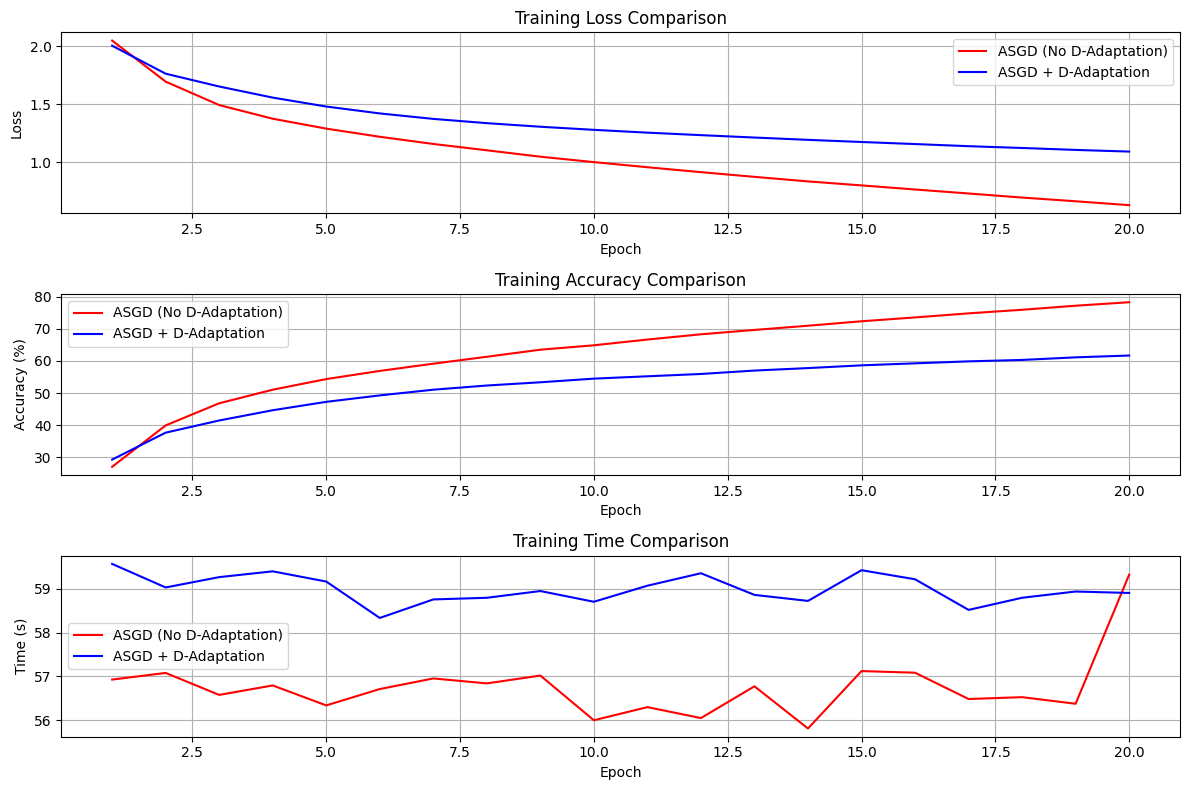

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import ASGD
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Add path for DAdaptASGD
import sys
sys.path.append('/content/dadaptation/dadaptation-main/dadaptation')
from dadapt_asgd import DAdaptASGD  # Import ASGD with D-Adaptation

# Training function
def train_model_with_logging(model, optimizer, criterion, train_loader, epochs=10):
    model.train()
    epoch_losses, epoch_accuracies, epoch_times = [], [], []

    for epoch in range(epochs):
        start_time = time.time()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        epoch_time = time.time() - start_time

        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)
        epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s")

    return epoch_losses, epoch_accuracies, epoch_times

# Prepare CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training with ASGD (No D-Adaptation)
print("Training with ASGD (No D-Adaptation)")
model_asgd = SimpleCNN()
optimizer_asgd = ASGD(model_asgd.parameters(), lr=1)
criterion = nn.CrossEntropyLoss()
asgd_losses, asgd_accuracies, asgd_times = train_model_with_logging(
    model_asgd, optimizer_asgd, criterion, train_loader, epochs=20
)

# Training with ASGD + D-Adaptation
print("\nTraining with ASGD + D-Adaptation")
model_dadapt_asgd = SimpleCNN()
optimizer_dadapt_asgd = DAdaptASGD(model_dadapt_asgd.parameters(), lr=0.01)
dadapt_asgd_losses, dadapt_asgd_accuracies, dadapt_asgd_times = train_model_with_logging(
    model_dadapt_asgd, optimizer_dadapt_asgd, criterion, train_loader, epochs=20
)

# Plot results
plt.figure(figsize=(12, 8))

# Loss comparison
plt.subplot(3, 1, 1)
plt.plot(range(1, len(asgd_losses) + 1), asgd_losses, label='ASGD (No D-Adaptation)', color='red', linestyle='-')
plt.plot(range(1, len(dadapt_asgd_losses) + 1), dadapt_asgd_losses, label='ASGD + D-Adaptation', color='blue', linestyle='-')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy comparison
plt.subplot(3, 1, 2)
plt.plot(range(1, len(asgd_accuracies) + 1), asgd_accuracies, label='ASGD (No D-Adaptation)', color='red', linestyle='-')
plt.plot(range(1, len(dadapt_asgd_accuracies) + 1), dadapt_asgd_accuracies, label='ASGD + D-Adaptation', color='blue', linestyle='-')
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

# Training time comparison
plt.subplot(3, 1, 3)
plt.plot(range(1, len(asgd_times) + 1), asgd_times, label='ASGD (No D-Adaptation)', color='red', linestyle='-')
plt.plot(range(1, len(dadapt_asgd_times) + 1), dadapt_asgd_times, label='ASGD + D-Adaptation', color='blue', linestyle='-')
plt.title("Training Time Comparison")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()